In [2]:
import requests 
import json
import xmltodict
import time
import statistics as st
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [4]:
#IMPROVEMENT: Include genes in regulatory domains as the ones specified by Peyregne: 1kb down or up; or something similar.
selection_of_genes='Data/genes_per_overlapped_regions.xlsx' #pd.read_excel(selection_of_genes) 
chr1="Data/genes_desert_chr_1_37.csv"
chr3="Data/genes_desert_chr_3_37.csv"
chr7="Data/genes_desert_chr_7_37.csv"
chr8="Data/genes_desert_chr_8_37.csv"
core_genes="Data/all_genes_core_regions.csv"
ELS_genes="Data/all_genes_ELS_regions.csv"

gene_expression="Data/aba7721_TablesS1-S16.xlsx"

### Getting genes and gene expression

In [9]:
# Genes
df=pd.read_csv(chr1,sep=";") 
#df=pd.read_csv(chr1,sep=";") 
geneschr1=df
df=pd.read_csv(chr3,sep=";") 
#df=pd.read_csv(chr1,sep=";") 
geneschr3=df
df=pd.read_csv(chr7,sep=";") 
#df=pd.read_csv(chr1,sep=";") 
geneschr7=df
df=pd.read_csv(chr8,sep=";") 
#df=pd.read_csv(chr1,sep=";") 
geneschr8=df


In [10]:
# Gene expression

#Gene - Cell type
gene_cell_type=pd.read_excel(gene_expression,sheet_name="Table_S4",header=1)
gene_cell_type["gene_short_name"]=gene_cell_type["gene_short_name"].str.replace("'", "")
gene_cell_type["gene_id"]=gene_cell_type["gene_id"].str[0:15]

C:\Users\Usuario\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [11]:
#Cell type - organ
cell_organ=pd.read_excel(gene_expression,sheet_name="Table_S3",header=1)
cell_organ.head()

,Cell_ID,Organ,Main cell type annotation,Gene markers supporting annotation,Reference literature (PMID or website),Cell_num,mean_mRNA_count,median_mRNA_count,mean_gene_count,median_gene_count,median_exonic_reads_ratio,fetus_number,CV_accuracy,CV_recall,CV_F1_score
0,Lung-Bronchiolar and alveolar epithelial cells,Lung,Bronchiolar and alveolar epithelial cells,"EPCAM, CDH1, AGER, SFTPB, SFTPA1, SFTPC","30283141, 29775597, 30554520",101249,705.038776,505.0,531.655216,407.0,0.512915,11,0.995020,0.999000,0.997006
1,Lung-Stromal cells,Lung,Stromal cells,"PDGFRB, COL1A1, DCN, ACTA2, TAGLN, MYH11, COL3...","30283141, 29775597, 30554520",87037,459.095534,383.0,352.741087,304.0,0.329091,11,0.994530,1.000000,0.997258
2,Lung-Ciliated epithelial cells,Lung,Ciliated epithelial cells,"TPPP3, FOXJ1, CD24A, SCGB1A1","30283141, 29775597, 30554520",2588,756.136785,565.0,562.329985,447.0,0.609581,11,0.999500,1.000000,0.999750
3,Lung-Neuroendocrine cells,Lung,Neuroendocrine cells,ASCL1,"30283141, 29775597, 30554520",1524,555.893701,437.5,420.364829,346.0,0.593915,11,0.998684,0.996063,0.997372
4,Lung-Squamous epithelial cells,Lung,Squamous epithelial cells,"TMPRSS11B, KRT13","27880766, 25851906",282,564.145390,450.0,348.719858,295.5,0.931696,11,0.996441,0.992908,0.994671


In [6]:
# Obtaining relation cell type - organ
rel_cell_organ=cell_organ[["Organ","Main cell type annotation"]]

#Cleaning
rel_cell_organ_dict=dict()
for i,row in rel_cell_organ.iterrows():
    cell_type=row["Main cell type annotation"]
    if cell_type in rel_cell_organ_dict.keys():
        rel_cell_organ_dict[cell_type]=rel_cell_organ_dict[cell_type]+" or "+row["Organ"]
    else:
        rel_cell_organ_dict[cell_type]=row["Organ"]
        
cell_organs_list=[list(rel_cell_organ_dict.values()),list(rel_cell_organ_dict.keys())]
cell_organs=pd.DataFrame(cell_organs_list).T
cell_organs.columns=["Organ","Main cell type annotation"]
cell_organs.head()

,Organ,Main cell type annotation
0,Lung,Bronchiolar and alveolar epithelial cells
1,Lung or Heart or Placenta or Adrenal or Muscle...,Stromal cells
2,Lung or Stomach,Ciliated epithelial cells
3,Lung or Stomach,Neuroendocrine cells
4,Lung or Stomach,Squamous epithelial cells


### Genes and cell types

In [12]:
ensemblID=[*geneschr1["EnsemblID"]]+[*geneschr3["EnsemblID"]]+[*geneschr7["EnsemblID"]]+[*geneschr8["EnsemblID"]]
# for i in geneschr8["EnsemblID"]:
#     if i in gene_cell_type["gene_id"].values:
#         print(i)

introgression_genes=gene_cell_type[gene_cell_type["gene_id"].isin(ensemblID)]

In [13]:
genes_pos_sel=pd.read_excel(selection_of_genes)
ensemblIDCore=list(genes_pos_sel[genes_pos_sel["kind_region"]=="core"]["EnsemblID"])
ensemblIDExt=list(genes_pos_sel["EnsemblID"])

In [9]:
# Inlucindg organs
cellMax_organ=cell_organs[["Organ","Main cell type annotation"]]
cellMax_organ.columns=["OrganMax","max.cluster"]
cellSecond_organ=cell_organs[["Organ","Main cell type annotation"]]
cellSecond_organ.columns=["OrganSecond","second.cluster"]
columns=introgression_genes.columns
introgression_genesF=introgression_genes.merge(cellMax_organ,on=["max.cluster"]).merge(cellSecond_organ,on=["second.cluster"])
introgression_genesF.head(10)

,gene_id,gene_short_name,gene_type,max.cluster,second.cluster,max.expr,second.expr,fold.change,pval,qval,OrganMax,OrganSecond
0,ENSG00000225036,RP11-414B7.1,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
1,ENSG00000270342,RP11-478L17.1,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
2,ENSG00000270976,RP11-110F24.1,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
3,ENSG00000232551,RP11-233E12.2,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
4,ENSG00000264753,AL390036.1,miRNA,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
5,ENSG00000226483,RP5-964H19.2,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
6,ENSG00000228054,RANP5,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
7,ENSG00000206832,RNU6V,snRNA,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
8,ENSG00000207709,MIR197,miRNA,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal
9,ENSG00000224927,NDUFA5P10,pseudogene,Acinar cells,Adrenocortical cells,0.0,0.0,1.0,1.0,1.0,Pancreas,Adrenal


### First test: average gene expression cerebrum and cerebellum compared with the rest of organs

In [10]:
cerebr_cerebel=introgression_genesF[introgression_genesF["OrganMax"].str.contains("Cerebrum|Cerebellum")][['max.expr']].mean()

rest_of_organs=introgression_genesF[~introgression_genesF["OrganMax"].str.contains("Cerebrum|Cerebellum")][['max.expr']].mean()

print("Cerebrum and cerebellum: ",cerebr_cerebel["max.expr"],", rest of the organs: ",rest_of_organs["max.expr"],
     ", Total: ",introgression_genesF[['max.expr']].mean()["max.expr"])

Cerebrum and cerebellum:  462.9880340630743 , rest of the organs:  130.25627561135633 , Total:  178.38490126439524


The results seem to show higher gene expression in cell types brain-related
More investigation needed.

## Differential gene expression per cells 

In [5]:
DE_gene_cells=pd.read_csv("Data/GSE156793_S8_DE_gene_cells.csv")
DE_gene_cells['gene_id'] = DE_gene_cells['gene_id'].map(lambda x: str(x).split(".")[0])
DE_gene_cells.head()

,organ,gene_id,gene_short_name,gene_type,max.cluster,second.cluster,max.expr,second.expr,fold.change,pval,qval
0,Adrenal,ENSG00000135346,'CGA',protein_coding,CSH1_CSH2 positive cells,Sympathoblasts,9519.045062,1.518893,6226.110471,0.0,0.0
1,Adrenal,ENSG00000136488,'CSH1',protein_coding,CSH1_CSH2 positive cells,Sympathoblasts,25536.878400,4.822877,5283.993555,0.0,0.0
2,Adrenal,ENSG00000137869,'CYP19A1',protein_coding,CSH1_CSH2 positive cells,Myeloid cells,6589.965874,4.546544,1446.266217,0.0,0.0
3,Adrenal,ENSG00000169704,'GP9',protein_coding,Megakaryocytes,Vascular endothelial cells,1364.708659,1.537244,882.031802,0.0,0.0
4,Adrenal,ENSG00000163737,'PF4',protein_coding,Megakaryocytes,Lymphoid cells,10218.956730,13.293575,768.136918,0.0,0.0


In [14]:
# Filtering by introgression deserts genes
DE_gene_cellsF=DE_gene_cells[DE_gene_cells["gene_id"].isin(ensemblID)]
DE_gene_cellsCore=DE_gene_cells[DE_gene_cells["gene_id"].isin(ensemblIDCore)]
DE_gene_cellsExt=DE_gene_cells[DE_gene_cells["gene_id"].isin(ensemblIDExt)]
print(len(ensemblID))

878


### Comparing expression values between introgression deserts and the rest 

In [13]:
print("Cerebrum")
print("Mean(introgression desert):",DE_gene_cellsF[DE_gene_cellsF["organ"]=="Cerebrum"][["max.expr"]].mean()[0])
print("Mean(general):",DE_gene_cells[DE_gene_cells["organ"]=="Cerebrum"][["max.expr"]].mean()[0])


Cerebrum
Mean(introgression desert): 220.43537821482263
Mean(general): 100.42693493571024


In [117]:
print("Cerebellum")
print("Mean(introgression desert):",DE_gene_cellsF[DE_gene_cellsF["organ"]=="Cerebellum"][["max.expr"]].mean()[0])
print("Mean(general):",DE_gene_cells[DE_gene_cells["organ"]=="Cerebellum"][["max.expr"]].mean()[0])

Cerebellum
Mean(introgression desert): 213.55732737141483
Mean(general): 98.652446722724


In [118]:
print("Liver")
print("Mean(introgression desert):",DE_gene_cellsF[DE_gene_cellsF["organ"]=="Liver"][["max.expr"]].mean()[0])
print("Mean(general):",DE_gene_cells[DE_gene_cells["organ"]=="Liver"][["max.expr"]].mean()[0])

Liver
Mean(introgression desert): 121.51434654590055
Mean(general): 139.99952896126482


In [119]:
print("Cerebellum")
print("Mean(introgression desert):",DE_gene_cellsF[DE_gene_cellsF["organ"]=="Stomach"][["max.expr"]].mean()[0])
print("Mean(general):",DE_gene_cells[DE_gene_cells["organ"]=="Stomach"][["max.expr"]].mean()[0])

Cerebellum
Mean(introgression desert): 220.61804901085068
Mean(general): 229.58804227308818


#### Using genes in introgression deserts

In [41]:
DE_gene_cellsF_grouped=DE_gene_cellsF.groupby("organ")[["max.expr"]].mean()
DE_gene_cells_grouped=DE_gene_cells.groupby("organ")[["max.expr"]].mean()
DE_means=DE_gene_cellsF_grouped.merge(DE_gene_cells_grouped,on=["organ"])
DE_means.columns=["IntrogrDes","General"]
DE_means["diff"]=DE_means["IntrogrDes"]-DE_means["General"]
# DE_means.sort_values(by=["diff"],ascending=False).to_excel("geneExpression_organs.xlsx")
DE_means.sort_values(by=["diff"],ascending=False)


,IntrogrDes,General,diff
organ,,,
Cerebrum,220.435378,100.426935,120.008443
Cerebellum,213.557327,98.652447,114.904881
Eye,263.368100,197.767413,65.600687
Thymus,172.098831,150.462234,21.636597
Adrenal,168.376757,148.126277,20.250479
Lung,188.656016,169.013687,19.642329
Heart,205.631080,188.805142,16.825938
Intestine,152.083610,140.939874,11.143736
Muscle,204.868270,200.097230,4.771040


#### Using genes from positive selection from the core  set

In [64]:
DE_gene_cellsCore_grouped=DE_gene_cellsCore.groupby("organ")[["max.expr"]].mean()
DE_gene_cells_grouped=DE_gene_cells.groupby("organ")[["max.expr"]].mean()
DE_meansCore=DE_gene_cellsCore_grouped.merge(DE_gene_cells_grouped,on=["organ"])
DE_meansCore.columns=["IntrogrDes","General"]
DE_meansCore["diff"]=DE_meansCore["IntrogrDes"]-DE_meansCore["General"]
DE_meansCore.sort_values(by=["diff"],ascending=False).to_excel("geneExpression_organsCore.xlsx")
DE_meansCore.sort_values(by=["diff"],ascending=False)

,IntrogrDes,General,diff
organ,,,
Cerebrum,1473.732303,100.426935,1373.305368
Heart,1150.265126,188.805142,961.459984
Lung,1045.889190,169.013687,876.875503
Eye,1030.143167,197.767413,832.375754
Cerebellum,869.348003,98.652447,770.695556
Intestine,828.137757,140.939874,687.197883
Thymus,678.118316,150.462234,527.656082
Liver,612.597504,139.999529,472.597975
Adrenal,561.049821,148.126277,412.923544


#### Using genes from positive selection also from the extended set

In [65]:
DE_gene_cellsExt_grouped=DE_gene_cellsExt.groupby("organ")[["max.expr"]].mean()
DE_gene_cells_grouped=DE_gene_cells.groupby("organ")[["max.expr"]].mean()
DE_meansExt=DE_gene_cellsExt_grouped.merge(DE_gene_cells_grouped,on=["organ"])
DE_meansExt.columns=["IntrogrDes","General"]
DE_meansExt["diff"]=DE_meansExt["IntrogrDes"]-DE_meansExt["General"]
DE_meansExt.sort_values(by=["diff"],ascending=False).to_excel("geneExpression_organsExtended.xlsx")
DE_meansExt.sort_values(by=["diff"],ascending=False)

,IntrogrDes,General,diff
organ,,,
Cerebrum,1254.580437,100.426935,1154.153502
Cerebellum,1087.287677,98.652447,988.635231
Eye,711.241346,197.767413,513.473933
Heart,667.719833,188.805142,478.914691
Intestine,567.299375,140.939874,426.359501
Lung,551.638368,169.013687,382.624682
Thymus,442.019292,150.462234,291.557058
Adrenal,390.275078,148.126277,242.148801
Liver,353.370621,139.999529,213.371092


These are just a few tests but the results with the S5 data looks quite interesting. In Introgression deserts the expression values in the Cerebellum and Cerebrum is completely different than in the rest of the organs

## Tests

In [138]:
import scipy.stats
import math
import statistics as st

### Chi-squared tests

In [79]:
# Chi-square test for Introgression deserts
print("Introgression deserts: ",scipy.stats.chisquare(DE_means["IntrogrDes"],DE_means["General"]))

# Chi-square test for Introgression deserts overlapp with PeyCore
print("Introgression deserts overlapp with Peyregne Core: ",scipy.stats.chisquare(DE_meansCore["IntrogrDes"],DE_meansCore["General"]))

# Chi-square test for Introgression deserts overlapp with PeyExtended set
print("Introgression deserts overlapp with Peyregne Extended Set: ",scipy.stats.chisquare(DE_meansExt["IntrogrDes"],DE_meansExt["General"]))




Introgression deserts:  Power_divergenceResult(statistic=335.5344846983951, pvalue=4.428342204722852e-63)
Introgression deserts overlapp with Peyregne Core:  Power_divergenceResult(statistic=47834.538705416046, pvalue=0.0)
Introgression deserts overlapp with Peyregne Extended Set:  Power_divergenceResult(statistic=29757.313231199947, pvalue=0.0)


### Permutation test

In [145]:
cerebrum=list()
cerebellum=list()
for i in range(1000):
    #Using 878 a similar number of genes as in Introgression deserts
    DE_gene_cellsS_grouped=DE_gene_cells.sample(878).groupby("organ")[["max.expr"]].mean()
    DE_gene_cells_grouped=DE_gene_cells.groupby("organ")[["max.expr"]].mean()
    DE_meansS=DE_gene_cellsS_grouped.merge(DE_gene_cells_grouped,on=["organ"])
    DE_meansS.columns=["RandDes","General"]
    DE_meansS["diff"]=DE_meansS["RandDes"]-DE_meansS["General"]
    # DE_means.sort_values(by=["diff"],ascending=False).to_excel("geneExpression_organs.xlsx")
    DE_meansS.sort_values(by=["diff"],ascending=False)

    DE_perm=DE_means.merge(DE_meansS,on=["organ"])
    DE_subCereb=DE_perm.loc[ ['Cerebrum' , 'Cerebellum'] , : ]["RandDes"]
    cerebrum.append(DE_subCereb["Cerebrum"])
    cerebellum.append(DE_subCereb["Cerebellum"])
    
    if DE_subCereb["Cerebellum"]>213.55:
        print("mayor que cerebellum")
    if DE_subCereb["Cerebrum"]>220.43:
        print("mayor que cerebrum")
print("Avg cerebrum: ",st.mean(cerebrum))
print("Cerebellum: ",st.mean(cerebellum))
# print("Introgression deserts: ",scipy.stats.chisquare(DE_perm["diff_y"],DE_perm["diff_x"]))

mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebellum
mayor que cerebrum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor que cerebrum
mayor que cerebrum
mayor que cerebellum
mayor que cerebrum
mayor que cerebellum
mayor que cerebellum
mayor que cerebellum
mayor q

In [164]:
print("Random samples with avg value at the cerebellum smaller than in Introgression Deserts: ",
      len([i for i in cerebellum if i<213.55]),"over 1000")
print("Random samples with avg value at the cerebrum smaller than in Introgression Deserts: ",
      len([i for i in cerebrum if i<220.43]),"over 1000")

Random samples with avg value at the cerebellum smaller than in Introgression Deserts:  956 over 1000
Random samples with avg value at the cerebrum smaller than in Introgression Deserts:  973 over 1000


With this results we can say that the samples using introgression deserts in the cerebrum and cerebellum have values over the 95%. 

## Plots

### Plots with cerebrum and cerebellum

In [20]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Max value

#Filter first by cerebrum and cerebellum
exp_cerebr_cerebel=introgression_genesF[(introgression_genesF["OrganMax"]=="Cerebrum") | (introgression_genesF["OrganMax"]=="Cerebrum") | (introgression_genesF["OrganMax"]=="Cerebrum or Cerebellum")]
#Plotting using value of expression and fold change
fig = px.scatter(DE_gene_cellsF[(DE_gene_cellsF["organ"]=="Cerebrum") | (DE_gene_cellsF["organ"]=="Cerebrum")], x="max.expr", y="fold.change", color="max.cluster",
                 hover_name="gene_short_name")

fig.show()

In [33]:
# Second value
#Filter first by cerebrum and cerebellum
exp_cerebr_cerebel=introgression_genesF[(introgression_genesF["OrganSecond"]=="Cerebrum") | (introgression_genesF["OrganSecond"]=="Cerebrum") | (introgression_genesF["OrganSecond"]=="Cerebrum or Cerebellum")]
#Plotting using value of expression and fold change
fig = px.scatter(DE_gene_cellsF[(DE_gene_cellsF["organ"]=="Cerebrum") | (DE_gene_cellsF["organ"]=="Cerebrum")], x="second.expr", y="fold.change", color="second.cluster",
                 hover_name="gene_short_name")

fig.show()

In [120]:
# Plot using S5 in introgression deserts
exp_cerebr_cerebel=DE_gene_cellsF[(DE_gene_cellsF["organ"]=="Cerebellum") |(DE_gene_cellsF["organ"]=="Cerebrum")  ]
#Plotting using value of expression and fold change
fig = px.scatter(DE_gene_cellsF, x="max.expr", y="fold.change", color="max.cluster",
                 hover_name="gene_short_name")

fig.show()

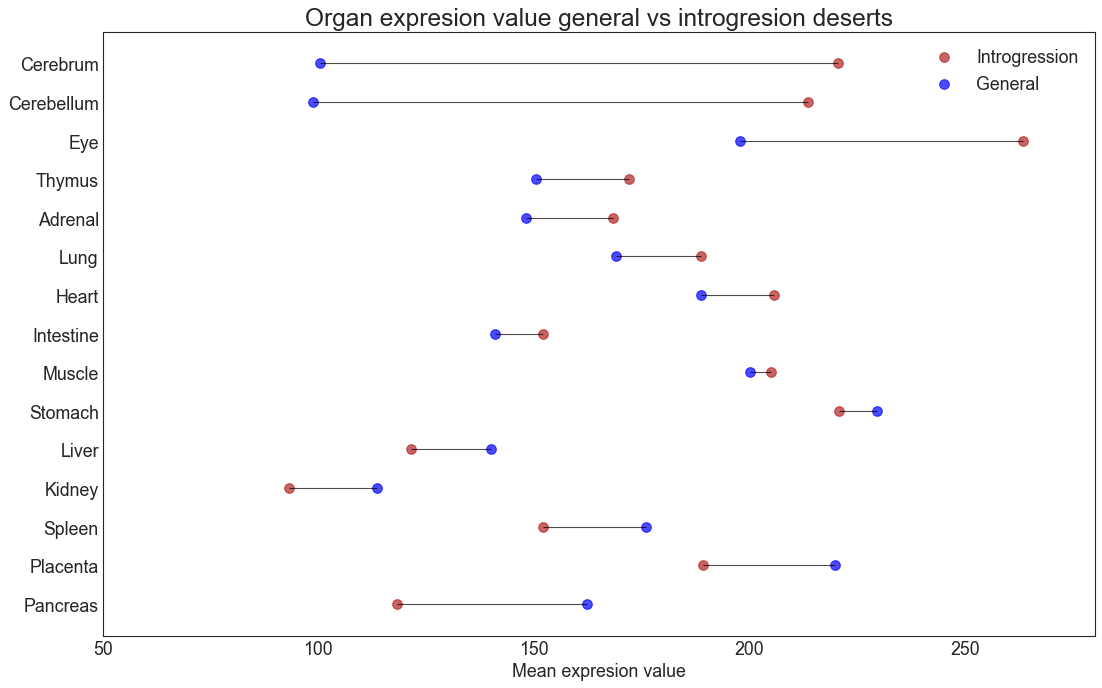

In [73]:
# Prepare Data Introgression deserts
DE_gene_cellsFTemp=DE_means.sort_values(by=["diff"],ascending=True) # DE_means (whole) DE_meansCore DE_meansExt
DE_gene_cellsFTemp=DE_gene_cellsFTemp.reset_index()

# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=DE_gene_cellsFTemp.index, xmin=DE_gene_cellsFTemp.General, xmax=DE_gene_cellsFTemp.IntrogrDes, color='black', alpha=0.7, linewidth=1)
p1=ax.scatter(y=DE_gene_cellsFTemp.index, x=DE_gene_cellsFTemp.IntrogrDes, s=75, color='firebrick', alpha=0.7)
p2=ax.scatter(y=DE_gene_cellsFTemp.index, x=DE_gene_cellsFTemp.General, s=75, color='blue', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Organ expresion value general vs introgresion deserts', fontdict={'size':22}) #+Peyregne Core or Ext
ax.set_xlabel('Mean expresion value')
ax.set_yticks(DE_gene_cellsFTemp.index)
ax.set_yticklabels(DE_gene_cellsFTemp.organ.str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(50, 280) #1500 for Core and Ext
plt.legend([p1, p2], ['Introgression','General'])
plt.show()

### Preview

In [69]:
ordered_gene_celltype=introgression_genesF.sort_values(by=["max.expr"],ascending=False)
ordered_gene_celltype.to_excel("gene_expression_per_cell_type.xlsx")
introgression_genesF.sort_values(by=["max.expr"],ascending=False).head(20)

,gene_id,gene_short_name,gene_type,max.cluster,second.cluster,max.expr,second.expr,fold.change,pval,qval,OrganMax,OrganSecond
653,ENSG00000175161,CADM2,protein_coding,Bipolar cells,Oligodendrocytes,10740.742827,10459.104637,1.026928,0.0,0.0,Eye,Cerebrum or Cerebellum
547,ENSG00000184408,KCND2,protein_coding,Oligodendrocytes,Granule neurons,8188.104467,4594.558592,1.782129,0.0,0.0,Cerebrum or Cerebellum,Cerebellum
253,ENSG00000185008,ROBO2,protein_coding,Excitatory neurons,SATB2_LRRC7 positive cells,7651.647406,7252.083819,1.055096,0.0,0.0,Cerebrum,Heart
330,ENSG00000128512,DOCK4,protein_coding,Microglia,Horizontal cells,6278.182518,2083.134511,3.013806,0.0,0.0,Eye or Cerebrum or Cerebellum,Eye
544,ENSG00000169855,ROBO1,protein_coding,Sympathoblasts,Granule neurons,5789.519496,5530.025901,1.046924,0.0,0.0,Adrenal,Cerebellum
871,ENSG00000206579,XKR4,protein_coding,Inhibitory interneurons,Schwann cells,5150.143415,2894.117946,1.779518,0.0,0.0,Cerebellum,Heart or Adrenal or Muscle
234,ENSG00000128573,FOXP2,protein_coding,SKOR2_NPSR1 positive cells,Purkinje neurons,5125.904000,4667.800805,1.098141,0.0,0.0,Cerebrum,Cerebellum
272,ENSG00000091129,NRCAM,protein_coding,Lens fibre cells,PDE11A_FAM19A2 positive cells,4585.216749,2217.240481,2.067979,0.0,0.0,Eye,Eye
737,ENSG00000104388,RAB2A,protein_coding,PAEP_MECOM positive cells,CSH1_CSH2 positive cells,4292.061816,448.947558,9.560084,0.0,0.0,Placenta,Lung or Adrenal
661,ENSG00000106278,PTPRZ1,protein_coding,Oligodendrocytes,Astrocytes,4229.301583,2895.819072,1.460484,0.0,0.0,Cerebrum or Cerebellum,Eye or Cerebrum or Cerebellum
